# IMPORT LIBRARIES

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import seaborn as sns
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
#from tensorflow.keras.applications import VGG16, RESNet50, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input


import warnings

warnings.filterwarnings("ignore")

# DATA COLLECTION 

In [5]:
import os, shutil

src_dirs = [r"C:\Users\USER\Desktop\Desktop\waste_dataset\TRAIN", r"C:\Users\USER\Desktop\Desktop\waste_dataset\TEST"
]   
dst_dir = r'C:\Users\USER\Desktop\Desktop\merged_wastedata'

for src in src_dirs:
    for cls in os.listdir(src):
        src_cls = os.path.join(src, cls)
        dst_cls = os.path.join(dst_dir, cls)
        os.makedirs(dst_cls, exist_ok=True)
        for f in os.listdir(src_cls):
            shutil.copy(os.path.join(src_cls, f), os.path.join(dst_cls, f))


In [3]:
data_path= r'C:\Users\USER\Desktop\Desktop\merged_wastedata'
images=[]
labels=[]

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path,subfolder)
    if not os.path.isdir(subfolder_path):
          continue

    for image_filename in os.listdir(subfolder_path):
        image_path=os.path.join(subfolder_path,image_filename)
        images.append(image_path)

        labels.append(subfolder)

df=pd.DataFrame({'image' : images, 'label': labels})

# DATA CLEANING & PREPROCESSING

In [19]:
import os
import hashlib

dataset_dir = "merged_wastedata"

hashes = set()
duplicate_count = 0

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        path = os.path.join(root, file)

        with open(path, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()

        if filehash in hashes:
            print("Removing duplicate:", path)
            os.remove(path)
            duplicate_count += 1
        else:
            hashes.add(filehash)

print("Done!")
print("Total removed duplicates:", duplicate_count)

Removing duplicate: merged_wastedata\O\O_10330.jpg
Removing duplicate: merged_wastedata\O\O_1419.jpg
Removing duplicate: merged_wastedata\O\O_192.jpg
Removing duplicate: merged_wastedata\O\O_310.jpg
Removing duplicate: merged_wastedata\O\O_323.jpg
Removing duplicate: merged_wastedata\O\O_337.jpg
Removing duplicate: merged_wastedata\O\O_341.jpg
Removing duplicate: merged_wastedata\O\O_388.jpg
Removing duplicate: merged_wastedata\O\O_4.jpg
Removing duplicate: merged_wastedata\O\O_403.jpg
Removing duplicate: merged_wastedata\O\O_410.jpg
Removing duplicate: merged_wastedata\O\O_4463.jpg
Removing duplicate: merged_wastedata\O\O_4464.jpg
Removing duplicate: merged_wastedata\O\O_4466.jpg
Removing duplicate: merged_wastedata\O\O_4467.jpg
Removing duplicate: merged_wastedata\O\O_4469.jpg
Removing duplicate: merged_wastedata\O\O_4470.jpg
Removing duplicate: merged_wastedata\O\O_4471.jpg
Removing duplicate: merged_wastedata\O\O_4472.jpg
Removing duplicate: merged_wastedata\O\O_4473.jpg
Removing d

In [33]:
import os

base_path = "merged_wastedata"   # change this to your dataset folder

for class_name in os.listdir(base_path):
    class_folder = os.path.join(base_path, class_name)

    if not os.path.isdir(class_folder):
        continue

    # Map folder names
    if class_name == "O":
        new_class_name = "organic"
    elif class_name == "R":
        new_class_name = "recycle"
    else:
        new_class_name = class_name

    files = os.listdir(class_folder)

    for i, filename in enumerate(files, start=1):
        old_path = os.path.join(class_folder, filename)
        ext = os.path.splitext(filename)[1]

        new_name = f"{new_class_name}({i}){ext}"
        new_path = os.path.join(class_folder, new_name)

        os.rename(old_path, new_path)

print("Renaming complete!")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'merged_wastedata\\organic\\organic(10).jpg' -> 'merged_wastedata\\organic\\organic(2).jpg'

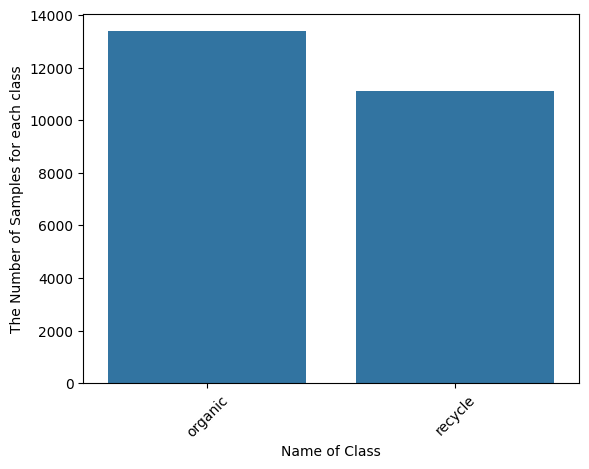

In [5]:
ax = sns.countplot(x=df.label)
ax.set_xlabel("Name of Class")
ax.set_ylabel("The Number of Samples for each class")
plt.xticks(rotation=45)
plt.show()

In [7]:
base_path = "merged_wastedata"

images = []
labels = []

for class_name in os.listdir(base_path):
    class_folder = os.path.join(base_path, class_name)
    if not os.path.isdir(class_folder):
        continue

    for filename in os.listdir(class_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            images.append(os.path.join(class_folder, filename))
            labels.append(class_name)

df = pd.DataFrame({'image': images, 'label': labels})

print("Total images:", len(df))
print("Classes:", df['label'].unique())

Total images: 24488
Classes: ['organic' 'recycle']


In [51]:
df.tail(15)

,image,label
24473,merged_wastedata\recycle\R_9986.jpg,recycle
24474,merged_wastedata\recycle\R_9987.jpg,recycle
24475,merged_wastedata\recycle\R_9988.jpg,recycle
24476,merged_wastedata\recycle\R_9989.jpg,recycle
24477,merged_wastedata\recycle\R_999.jpg,recycle
24478,merged_wastedata\recycle\R_9990.jpg,recycle
24479,merged_wastedata\recycle\R_9991.jpg,recycle
24480,merged_wastedata\recycle\R_9992.jpg,recycle
24481,merged_wastedata\recycle\R_9993.jpg,recycle
24482,merged_wastedata\recycle\R_9994.jpg,recycle


# DATA MODELING

In [11]:
X_train, X_test,y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])
df_train=pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
#encoder=LabelEncoder()
#y_train=encoder.fit_transform(y_train)
#y_test= encoder.transform(y_test)


In [13]:
image_size=(50,50)
batch_size=32

train_datagen= ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size= image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    df_test, 
    x_col='image',
    y_col='label',
    target_size= image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 19590 validated image filenames belonging to 2 classes.
Found 4898 validated image filenames belonging to 2 classes.


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

input_shape = (50,50,3)

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  

In [29]:
history = model.fit(train_generator,epochs=50, validation_data=test_generator) 

Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 76s 124ms/step - accuracy: 0.9481 - loss: 0.1377 - val_accuracy: 0.8965 - val_loss: 0.3639
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 75s 123ms/step - accuracy: 0.9452 - loss: 0.1374 - val_accuracy: 0.9004 - val_loss: 0.3502
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 76s 123ms/step - accuracy: 0.9475 - loss: 0.1344 - val_accuracy: 0.8902 - val_loss: 0.3667
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 76s 125ms/step - accuracy: 0.9441 - loss: 0.1483 - val_accuracy: 0.8728 - val_loss: 0.6502
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 76s 123ms/step - accuracy: 0.9445 - loss: 0.1386 - val_accuracy: 0.9000 - val_loss: 0.3712
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 75s 123ms/step - accuracy: 0.9467 - loss: 0.1393 - val_accuracy: 0.8993 - val_loss: 0.3432
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 75s 123ms/step - accuracy: 0.9424 - loss: 0.1513 - val_accuracy: 0.8887 - val_loss: 0.4046
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 76s 125ms/step - accuracy: 0.9478 - loss: 0

# MODEL PERFORMANCE & METRICS

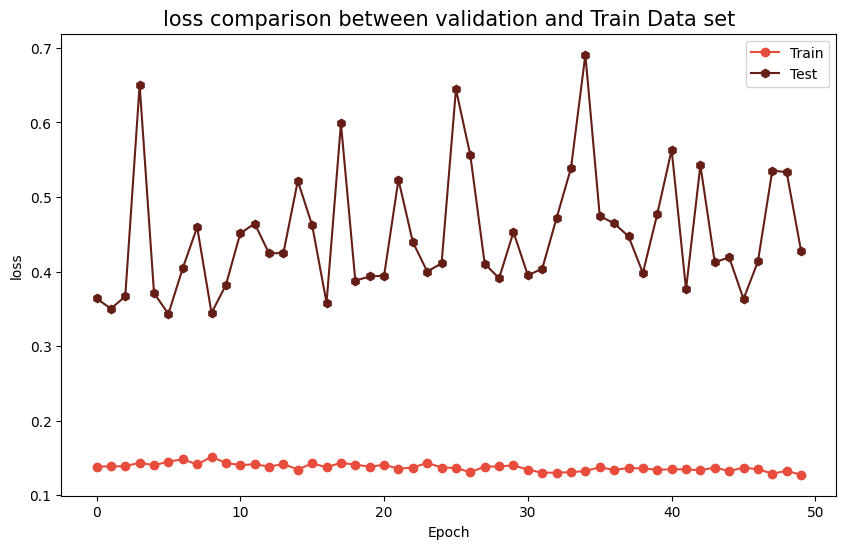

In [33]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color='#E74C3C', marker='o')
plt.plot(history.history['val_loss'], color='#641E16',marker='h')
plt.title('loss comparison between validation and Train Data set', fontsize=15)
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

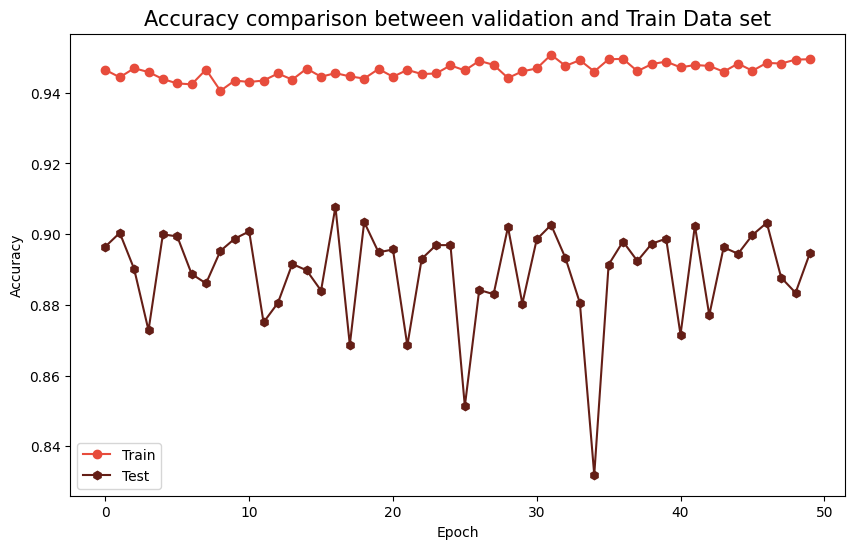

In [31]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], color='#E74C3C', marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16',marker='h')
plt.title('Accuracy comparison between validation and Train Data set', fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [35]:
y_pred_prob = model.predict(test_generator)

154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step


In [37]:
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

In [39]:
y_true = test_generator.classes

In [41]:
class_labels = list(test_generator.class_indices.keys())

In [43]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[2349  329]
 [ 187 2033]]


In [45]:
print(classification_report(y_true,y_pred, target_names=class_labels))

              precision    recall  f1-score   support

     organic       0.93      0.88      0.90      2678
     recycle       0.86      0.92      0.89      2220

    accuracy                           0.89      4898
   macro avg       0.89      0.90      0.89      4898
weighted avg       0.90      0.89      0.89      4898



In [47]:
model.save("waste_model.h5")

# MODEL DEPLOYMENT

In [49]:
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

# Load model
model = load_model("waste_model.h5")

# Updated class labels
class_names = ["organic", "recycle"]

st.set_page_config(page_title="waste Classifier", layout="centered")

st.title("🧴 Waste Classification App")
st.write("Upload a waste image and the model will predict the condition.")

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess image
    img = image.resize((50, 50))  # adjust to your model input size if different
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    st.markdown("### 🔍 Prediction Result")
    st.success(f"**{predicted_class.capitalize()}**")
    st.write(f"Confidence: **{confidence:.2f}%**")

2026-01-29 16:42:51.339 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-29 16:42:51.341 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-29 16:42:54.343 
  command:

    streamlit run C:\Users\USER\anaconda3\envs\tf-env\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2026-01-29 16:42:54.345 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-29 16:42:54.346 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-29 16:42:54.349 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-29 16:42:54.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignore

In [51]:
import os
# Create the folder
os.makedirs("waste_app", exist_ok=True)

# Create empty app.py file
open("waste_app/app.py", "w").close()

print("waste_app folder and app.py file created successfully!")


waste_app folder and app.py file created successfully!
